In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from config import get_default_cfg
from sae import VanillaSAE, TopKSAE, BatchTopKSAE, JumpReLUSAE
import transformer_lens
from transformer_lens import HookedTransformer, HookedEncoder
from transformers import GPT2Tokenizer, GPT2Model, BertModel, BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sentence_transformers import SentenceTransformer

---
Load the models

In [2]:
run = wandb.init()
artifact = run.use_artifact('ybiku-unir/SBERT-SAEs-PubMed/sentence-transformers_paraphrase-mpnet-base-v2_blocks.0.hook_embed_2304_jumprelu_16_0.0003_624:v0', type='model')
artifact_dir = artifact.download()

config_path = os.path.join(artifact_dir, 'config.json')
with open(config_path, 'r') as f:
    config = json.load(f)

if "dtype" in config and isinstance(config["dtype"], str):
    if config["dtype"] == "torch.float32":
        config["dtype"] = torch.float32
    elif config["dtype"] == "torch.float16":
        config["dtype"] = torch.float16

sae = BatchTopKSAE(config).to(config["device"])
sae.load_state_dict(torch.load(os.path.join(artifact_dir, 'sae.pt')))
sae.eval()

model = HookedEncoder.from_pretrained("bert-base-uncased").to(config["device"])
sbert = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ybiku (ybiku-unir) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  


RuntimeError: Error(s) in loading state_dict for BatchTopKSAE:
	Unexpected key(s) in state_dict: "jumprelu.log_threshold". 

In [35]:
prompt = "This is a prompt for testing the model."
with torch.no_grad():
    embeddings = sbert.encode(prompt, convert_to_tensor=True)
embeddings.shape

torch.Size([768])

In [36]:
import importlib
import activation_store
importlib.reload(activation_store)
from activation_store import ActivationsStoreSBERT

dataset = load_dataset("brainchalov/pubmed_arxiv_abstracts_data", split="train", trust_remote_code=True, streaming=True)
store = ActivationsStoreSBERT(sbert, config)

Repo card metadata block was not found. Setting CardData to empty.


In [29]:
store.next_batch

<bound method ActivationsStoreSBERT.next_batch of <activation_store.ActivationsStoreSBERT object at 0x000001A2591F4D90>>

In [30]:
column = store._get_tokens_column()
column

'abstr'

In [27]:
sample = next(iter(dataset))
print(sample.keys())

dict_keys(['abstr', 'title', 'journal', 'field', 'label_journal', 'label_field'])


---
### Neuron activation analysis of the Residual Stream of the 11th layer of BERT

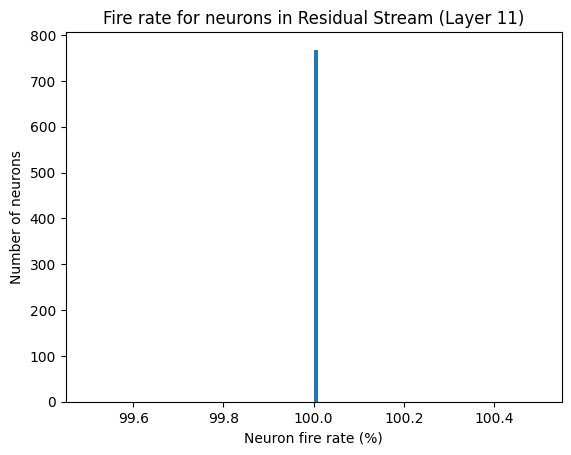

In [31]:
def hook_fn(act, hook):
    activation[hook.name] = act.detach()
    return act

dataset = load_dataset("EleutherAI/the_pile_deduplicated", split="train", streaming=True)
dataset = dataset.shuffle(seed=config["seed"]).take(int(1e4))
hook_point = config["hook_point"]
num_examples = 0
neuron_fire_count = torch.zeros(config["act_size"]).to(config["device"])

for example in dataset:
    num_examples += 1
    text = example['text']
    tokens_tuple = model.to_tokens(text, truncate=True, move_to_device=True)
    tokens = tokens_tuple[0].squeeze(0)
    if tokens.shape[0] > config["seq_len"]:
        tokens = tokens[:config["seq_len"]]
    elif tokens.shape[0] < config["seq_len"]:
        tokens = F.pad(tokens, (0, config["seq_len"] - tokens.shape[0]), value=model.tokenizer.pad_token_id)

    activation = {}
    with torch.no_grad():
        _ = model.run_with_hooks(
            tokens.unsqueeze(0),
            fwd_hooks=[(hook_point, hook_fn)]
        )
    activations = activation[hook_point]
    activations = activations.reshape(-1, config["act_size"]).to(config["device"])
    active_neurons = activations != 0
    neuron_fire_count_ex = torch.sum(active_neurons.int(), dim=0)
    neuron_fire_count_ex = neuron_fire_count_ex > 0
    neuron_fire_count_ex = neuron_fire_count_ex.int()
    neuron_fire_count += neuron_fire_count_ex

neuron_fire_count_percent = 100 * neuron_fire_count / num_examples


plt.hist(neuron_fire_count_percent.cpu().numpy(), bins=100)
plt.xlabel('Neuron fire rate (%)')
plt.ylabel('Number of neurons')
plt.title('Fire rate for neurons in Residual Stream (Layer 11)')
plt.show()

---
### Feature activation analysis of the x16 BatchTopK SAE on the Residual Stream of the 11th layer of BERT

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  cuda
Loaded pretrained model bert-base-uncased into HookedEncoder
Moving model to device:  cuda


C:\Users\Diego\AppData\Local\Temp\ipykernel_17084\3937738014.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


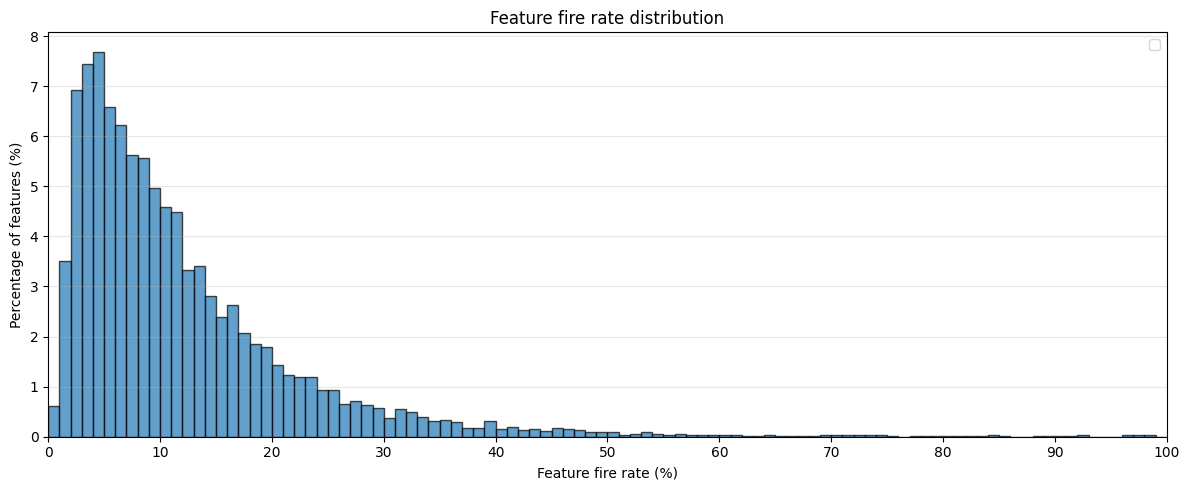

In [32]:
def hook_fn(act, hook):
    activation[hook.name] = act.detach()
    return act

model = HookedEncoder.from_pretrained("bert-base-uncased").to(config["device"])
hook_point = config["hook_point"]
feature_count = torch.ones(config["dict_size"], device=config["device"])
num_examples = 0
top_examples_per_feature = {i: [] for i in range(config["dict_size"])}

dataset = load_dataset("EleutherAI/the_pile_deduplicated", split="train", streaming=True)
dataset = dataset.shuffle(seed=config["seed"]).take(int(1e4))

for example in dataset:
    num_examples += 1
    text = example['text']
    tokens_tuple = model.to_tokens(text, truncate=True, move_to_device=True)
    tokens = tokens_tuple[0].squeeze(0)
    if tokens.shape[0] > config["seq_len"]:
        tokens = tokens[:config["seq_len"]]
    elif tokens.shape[0] < config["seq_len"]:
        tokens = F.pad(tokens, (0, config["seq_len"] - tokens.shape[0]), value=model.tokenizer.pad_token_id)

    activation = {}
    with torch.no_grad():
        _ = model.run_with_hooks(
            tokens.unsqueeze(0),
            fwd_hooks=[(hook_point, hook_fn)]
        )
    activations = activation[hook_point]
    batch_activations = activations.reshape(-1, config["act_size"]).to(config["device"])
    with torch.no_grad():
        sae_output = sae(batch_activations)

    feature_acts = sae_output["feature_acts"]
    max_activations, _ = torch.max(feature_acts, dim=0)

    feature_activations_token = (sae_output["feature_acts"] > 0)
    feature_activations_example = feature_activations_token.any(dim=0).int()
    feature_count += feature_activations_example

    for feature_idx in range(config["dict_size"]):
        activation_val = max_activations[feature_idx].item()
        if activation_val > 0:  # Solo guardar si hay activación
            # Guardar temporalmente todos los ejemplos
            top_examples_per_feature[feature_idx].append((activation_val, text))
            # Mantenemos ordenada la lista por valor de activación (descendente)
            top_examples_per_feature[feature_idx].sort(key=lambda x: x[0], reverse=True)
            # Mantenemos solo los 20 mejores ejemplos
            if len(top_examples_per_feature[feature_idx]) > 20:
                top_examples_per_feature[feature_idx] = top_examples_per_feature[feature_idx][:20]


feature_prob = feature_count / num_examples
feature_activation_pct = 100 * feature_prob

vals = feature_activation_pct.cpu().numpy()
num_features = len(vals)

counts, bins = np.histogram(vals, bins=100, range=(0,100))
counts_pct = (counts / num_features) * 100
bin_width = bins[1] - bins[0]
plt.figure(figsize=(12, 5))
plt.bar(
    bins[:-1],
    counts_pct,
    width=bin_width,
    align='edge',
    edgecolor='black',
    alpha=0.7
)
plt.xlabel('Feature fire rate (%)')
plt.ylabel('Percentage of features (%)')
plt.title('Feature fire rate distribution')
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

C:\Users\Diego\AppData\Local\Temp\ipykernel_17084\2709978782.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


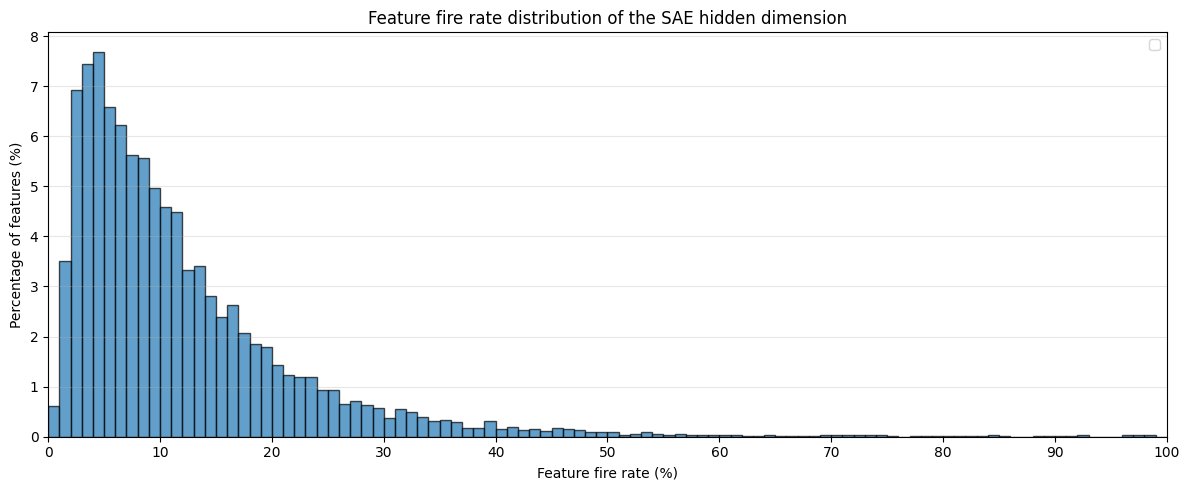

In [33]:
counts, bins = np.histogram(vals, bins=100, range=(0,100))
counts_pct = (counts / num_features) * 100
bin_width = bins[1] - bins[0]
plt.figure(figsize=(12, 5))
plt.bar(
    bins[:-1],
    counts_pct,
    width=bin_width,
    align='edge',
    edgecolor='black',
    alpha=0.7
)
plt.xlabel('Feature fire rate (%)')
plt.ylabel('Percentage of features (%)')
plt.title('Feature fire rate distribution of the SAE hidden dimension')
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

---
### Cosine similarity analysis of thematic datasets

In [33]:
num_examples = 20
dataset_embeddings = torch.zeros(num_examples, 768)

dataset = load_dataset("brainchalov/pubmed_arxiv_abstracts_data", split="train", trust_remote_code=True, streaming=True)
dataset = dataset.shuffle(seed=config["seed"]).take(int(num_examples))

for i, example in enumerate(dataset):
    if i >= num_examples: break
    text = example["abstr"]
    if len(text) > config["seq_len"]: text = text[:config["seq_len"]]
    elif len(text) < config["seq_len"]: text = text + " " * (config["seq_len"] - len(text))
    embed = sbert.encode(text, convert_to_tensor=True)
    dataset_embeddings[i] = embed

similarity_matrix = torch.zeros(dataset_embeddings.shape[0], dataset_embeddings.shape[0])
for i in range(dataset_embeddings.shape[0]):
    for j in range(dataset_embeddings.shape[0]):
        similarity_matrix[i, j] = F.cosine_similarity(
            dataset_embeddings[i].unsqueeze(0),
            dataset_embeddings[j].unsqueeze(0)
        )

Repo card metadata block was not found. Setting CardData to empty.


In [34]:
similarity_matrix

tensor([[ 1.0000e+00,  1.1460e-01,  2.0941e-01,  2.5548e-01,  1.8163e-01,
          1.8561e-01,  1.2880e-01,  2.8853e-01, -3.4348e-03,  1.7291e-01,
          3.7609e-02,  3.4524e-02,  3.6460e-01,  2.3592e-01,  2.8295e-01,
          2.9153e-01,  2.6152e-01,  8.9568e-02,  3.1548e-01,  1.3734e-01],
        [ 1.1460e-01,  1.0000e+00,  2.6318e-01,  1.5494e-01, -5.6090e-02,
          2.4295e-01,  2.2501e-01,  2.2609e-01,  1.5692e-01,  4.6332e-01,
          3.2029e-01,  1.1214e-01,  2.3209e-01,  2.4443e-01,  1.7690e-01,
          1.6723e-01,  2.6127e-01,  1.0026e-01,  2.1720e-01,  1.8838e-01],
        [ 2.0941e-01,  2.6318e-01,  1.0000e+00,  7.2204e-02,  9.0850e-02,
          2.0978e-01,  2.6841e-01,  2.5392e-01,  7.7784e-02,  5.1251e-01,
          1.0790e-01,  1.8197e-01,  2.4676e-01,  1.4586e-01,  2.4132e-01,
          1.8615e-01,  1.1647e-01,  1.8637e-01,  1.7242e-01,  1.6060e-01],
        [ 2.5548e-01,  1.5494e-01,  7.2204e-02,  1.0000e+00,  9.3573e-02,
          1.5523e-01,  4.8548e-02, 

<Axes: >

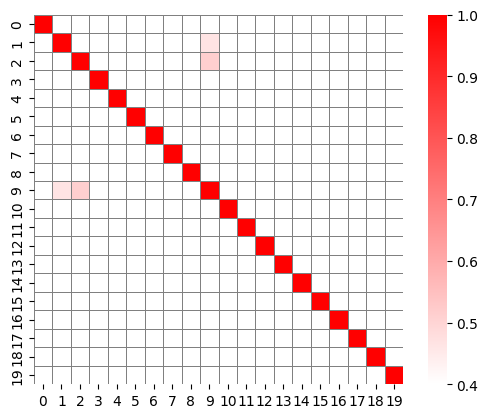

In [39]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("custom_red", ["white", "red"])

sns.heatmap(similarity_matrix, cmap=cmap, vmin=0.4, vmax=1.0, square=True, linewidths=0.5, linecolor='gray')

In [7]:
model = HookedEncoder.from_pretrained("bert-base-uncased")
model.embed.hook_embed

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  cuda
Loaded pretrained model bert-base-uncased into HookedEncoder


HookPoint()

In [3]:
model = HookedTransformer.from_pretrained("gpt2-small")
model

Loaded pretrained model gpt2-small into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h